In [1]:
import numpy as np
import plotly as py
py.offline.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
#preprocessing
import scipy.io as sio
import mne
import matplotlib.pyplot as plt

def inputmat(fp):
    """load .mat file and return m as a dict"""
    mat = sio.loadmat(fp, squeeze_me=True)
    td = {}  # create a dict

    # Numpy array of size channel_num * points.
    td['data'] = mat['cnt'].T  # data
    td['freq'] = mat['nfo']['fs'][True][0]  # Sampling frequency

    # channel names are necessary information for creating a rawArray.
    td['ch_names'] = mat['nfo']['clab'][True][0]

    # Position of channels
    
    td['electrode_x'] = mat['nfo']['xpos'][True][0]
    td['electrode_y'] = mat['nfo']['ypos'][True][0]

    #make trials by finding trials and its data
    td['cue'] = mat['mrk']['pos'][True][0] #time of cue
    td['labels'] = mat['mrk']['y'][True][0] #labels of the data
    return td


def creatEventsArray(fp):
    """Create events array. The second column default to zero."""
    td = inputmat(fp)
    events = np.zeros((td['labels'].size, 3), int) #here we have made a matrix type array of the size of label.size*3
#     print(events)
    events[:, 0] = td['cue']  # The first column is the sample number of the event.
#     print(events[:, 0])
    events[:, 2] = td['labels']  # The third column is the new event value.
#     print(events[:, 2])
    return events, td['labels']


def create_info(td):
    """Create MNE info object from the dataset dictionary"""
    ch_names = td['ch_names'].tolist()  # Channel names
    ch_types = ['eeg'] * len(ch_names)  # Assuming all channels are EEG

    # Assuming z-coordinate is set to 0 for all electrodes
    electrode_positions = np.column_stack([td['electrode_x'], td['electrode_y'], np.zeros(len(ch_names))])
    # fix electrode positions by scaling them
    electrode_positions = electrode_positions * 0.1
    # Create a montage using electrode positions
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, electrode_positions)),
                                            coord_frame='head')

    # Create info object without the montage
    info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=td['freq'])

    # Set the montage
    info.set_montage(montage)

    return info

def creatRawArray(fp):
    """Create a mne.io.RawArray object, data: array, shape (n_channels, n_times)"""
    td = inputmat(fp)
    
    # info = mne.create_info(ch_names, td['freq'], 'eeg')  # Create info for raw
    info = create_info(td)
    raw = mne.io.RawArray(td['data'], info, first_samp=0, copy='auto', verbose=None)
    return raw




In [3]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP


In [4]:
"""The files c, d, e are the artificial data so we can test out our labels in different ways in them"""


file1 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1a.mat'
file2 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1b.mat'

# artificial data files

file3 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1c.mat'
file4 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1d.mat'
file5 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1e.mat'
file6 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1f.mat'
file7 = r'Data 100hz/BCICIV_1_mat/BCICIV_calib_ds1g.mat'



"""making the file dictionary and channel dictionary for easy pickup"""
fp = {
    'ds1a': file1,
    'ds1b': file2,
    'ds1f': file6,
    'ds1g': file7,
}



""" Pick channels if necessary but not needed as we will be deploying a CSP pipeline ahead"""


low_freq, high_freq = 7., 30.
tmin, tmax = 0., 3.5

event_id = {'left': -1, 'foot': 1}

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


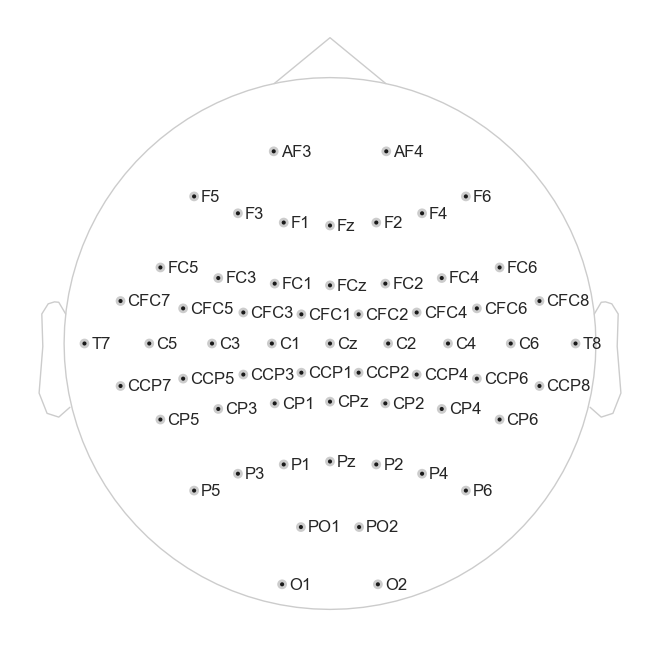

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Computing rank from data with rank=None
    Using tolerance 7.1e+02 (2.2e-16 eps * 59 dim * 5.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e+02 (2.2e-16 eps * 59 dim * 5.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


C:\Users\20121\AppData\Local\Temp\ipykernel_17756\2245988066.py:45: RuntimeWarning:

More than 25 topomaps plots requested. This might take a while.



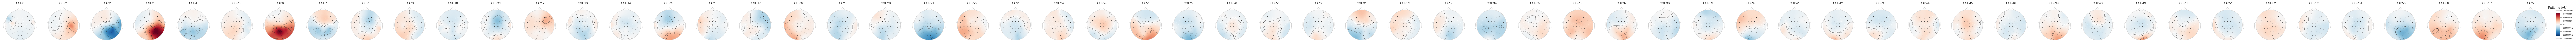

Computing rank from data with rank=None
    Using tolerance 7.1e+02 (2.2e-16 eps * 59 dim * 5.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e+02 (2.2e-16 eps * 59 dim * 5.3e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e+02 (2.2e-16 eps * 59 dim * 5.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7e+02 (2.2e-16 eps * 59 dim * 5.4e+16  max singular value)
  

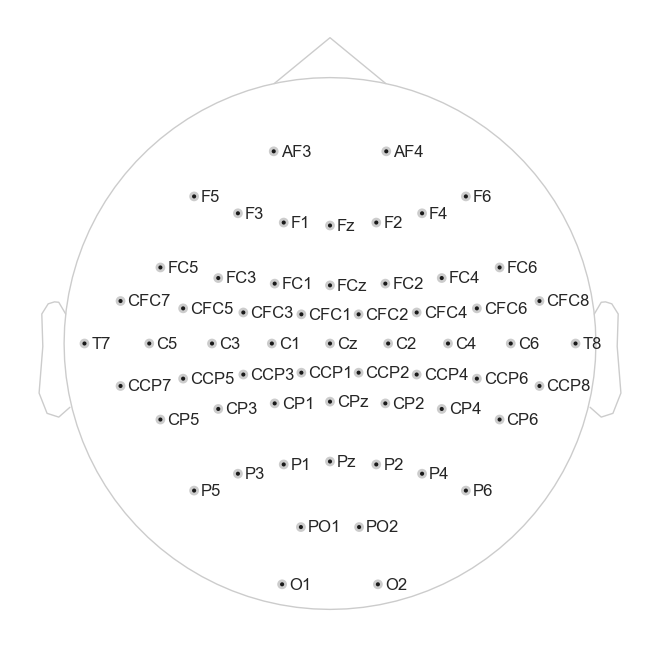

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 59 dim * 1.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 59 dim * 1.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


C:\Users\20121\AppData\Local\Temp\ipykernel_17756\2245988066.py:45: RuntimeWarning:

More than 25 topomaps plots requested. This might take a while.



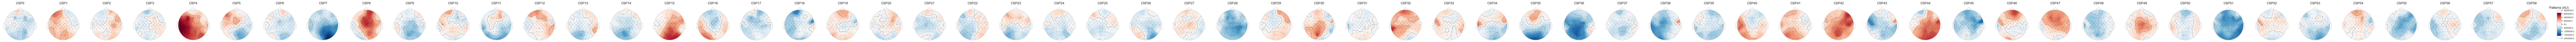

Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 59 dim * 1.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 59 dim * 1.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.4e+02 (2.2e-16 eps * 59 dim * 1.8e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3e+02 (2.2e-16 eps * 59 dim * 1.8e+16  max singular value)


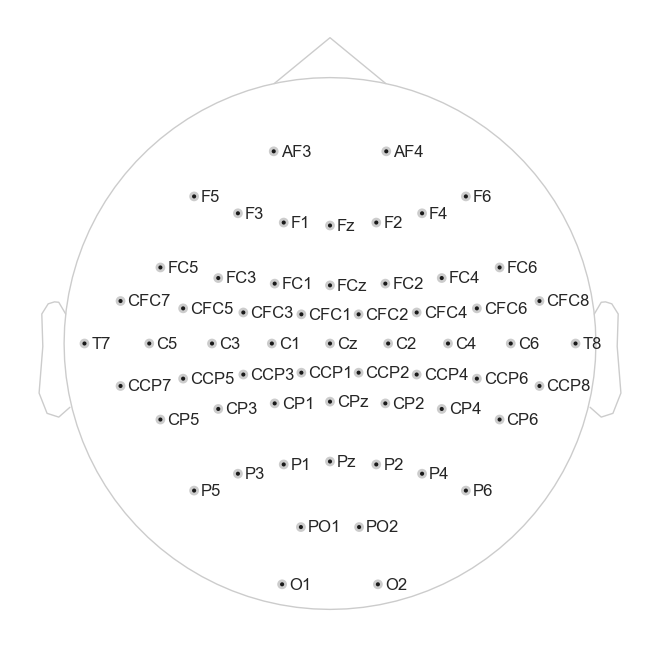

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Computing rank from data with rank=None
    Using tolerance 4.9e+02 (2.2e-16 eps * 59 dim * 3.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e+02 (2.2e-16 eps * 59 dim * 4.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


C:\Users\20121\AppData\Local\Temp\ipykernel_17756\2245988066.py:45: RuntimeWarning:

More than 25 topomaps plots requested. This might take a while.



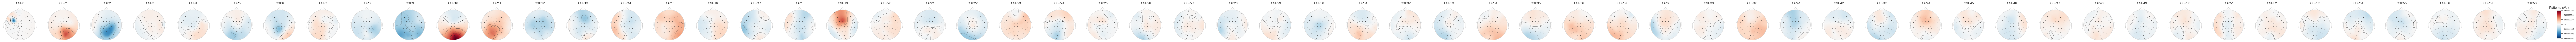

Computing rank from data with rank=None
    Using tolerance 4.9e+02 (2.2e-16 eps * 59 dim * 3.7e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.8e+02 (2.2e-16 eps * 59 dim * 4.4e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.1e+02 (2.2e-16 eps * 59 dim * 3.9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.7e+02 (2.2e-16 eps * 59 dim * 4.4e+16  max singular value)


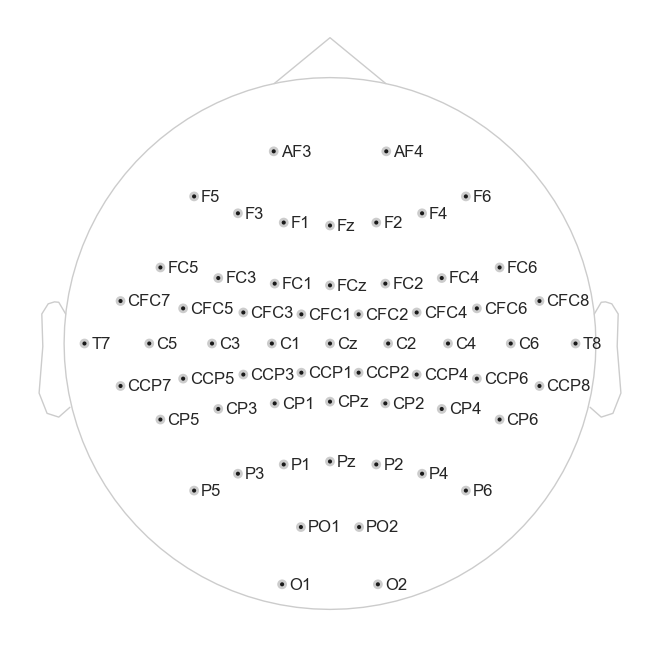

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.


C:\Users\20121\AppData\Local\Temp\ipykernel_17756\2245988066.py:45: RuntimeWarning:

More than 25 topomaps plots requested. This might take a while.



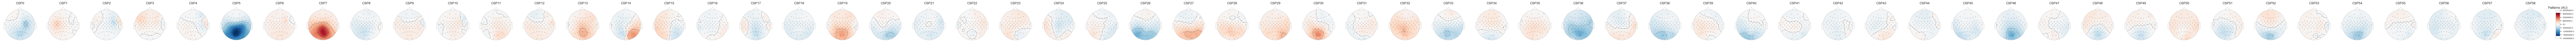

Computing rank from data with rank=None
    Using tolerance 1.2e+03 (2.2e-16 eps * 59 dim * 9e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e+03 (2.2e-16 eps * 59 dim * 1.1e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e+03 (2.2e-16 eps * 59 dim * 1e+17  max singular value)
    

In [5]:
"""code from the mne documentation
https://mne.tools/dev/auto_examples/decoding/plot_decoding_csp_eeg.html"""

#this is the MLP neural net classifier
from sklearn.neural_network import MLPClassifier
import pickle
x_test_global = []

for f in fp:
    raw = creatRawArray(fp[f])
    events, labels = creatEventsArray(fp[f])    
    # Use set_montage to apply the montage
    raw.plot_sensors(show_names=True)
    info = raw.info
    # Continue with your processing, e.g., filtering, epoching, and classification
    raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')
    

    # event_train = eventsTrain(fp[f])
    epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                        verbose=False)#, picks=picks)

    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    scores = []
    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()
    
    #shuffling the data
    cv = ShuffleSplit(5, test_size=0.2, random_state=42)
    cv_split = cv.split(epochs_data_train)
    
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(epochs_data_train, labels, test_size=0.2, random_state=42)
    if f == "ds1a":
        x_test_global = X_test
    
    # Assemble a classifier
    MLP_C = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=42)
    csp = CSP(n_components=len(epochs.ch_names), reg=None, log=True, norm_trace=False)


    csp.fit(X_train, y_train)
    csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)


    #pipleine to run the csp and mlp classifier
    clf = Pipeline([('CSP', csp), ('MLP_C', MLP_C)])
    scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1) 
    print('**********************************************************************************************')
    
    
    y_train_copy = y_train.copy()
    # print(y_train)
    for i in range(len(y_train)):
        if -1 == y_train[i]:
            y_train_copy[i] = 0
        else:
            y_train_copy[i] = 1
    
    # Training the model
    clf.fit(X_train, y_train_copy)
    
    # Saving the model
    saved_model=pickle.dumps(clf)
    
    #save model to pickle file
    filename = f + 'finalized_model.sav' 
    
    # wb means write in binary
    pickle.dump(clf, open(filename, 'wb'))
    
    # Prediction
    prediction = clf.predict(X_test)
    

    y_test_copy = y_test.copy()
    for i in range(len(y_test)):
        if -1 == y_test[i]:
            y_test_copy[i] = 0
        else:
            y_test_copy[i] = 1
    
    # Printing the results
    class_balance = np.mean(labels == labels[0])
    class_balance = max(class_balance, 1. - class_balance)
    print("Classification accuracy: %f  / Chance level: %f" % (np.mean(scores)*100, class_balance))
    
    #making the labels more generalized
    
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
    print('Predictions are as follows: ')
    print(prediction)
    print("Actual values are as follows")
    print(y_test_copy)
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')

In [6]:
#function to the load the save pickle model and predict it
def load_model_predict(X_test,saved_model_fname):
    import pickle
    # load the model from disk
    loaded_model = pickle.load(open(saved_model_fname, 'rb'))
    prediction = loaded_model.predict(X_test)
    return prediction

#Y predictions for the test data
y_pred =load_model_predict(x_test_global, 'ds1afinalized_model.sav')
print(y_pred.shape)

(40,)


In [7]:
print(x_test_global.shape)
# print one epoch data (epoch is a time window of 1 sec)
one_epoch = x_test_global[0, :, :]
print(one_epoch)

# save to csv file
data_dict = {
    "data": one_epoch,
    "ch_names": ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5',
                'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3',
                'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1',
                'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1',
                'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',
                'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1',
                'PO2', 'O1', 'O2'
                ]

}

import csv

def data_to_csv(data_dict, averaging=False, filename='data.csv'):
    """convert data from data_dict to csv file for one channel if averaging enabled"""
    data = data_dict['data']
    # labels = data_dict['labels']
    # freq = data_dict['freq']
    # cue = data_dict['cue']
    ch_names = data_dict['ch_names']
    if averaging:
        data = np.mean(data, axis=0)
        ch_names = ['Averaged']
        # create a new channel by averaging all the channels
        new_data = np.zeros((data.shape[1], 1))
        for i in range(data.shape[1]):
            new_data[i] = np.mean(data[:, i])
        data_dict['data'] = new_data
        data_dict['ch_names'] = ['Averaged']
    # write to csv
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(ch_names)
        for i in range(data.shape[1]):
            writer.writerow(data[:, i])
    return data_dict

data_to_csv(data_dict,filename="TestingData.csv")

(40, 59, 101)
[[ 48.16082196  43.5504309  -30.07300916 ... -45.62219848  -8.75427218
    6.88977219]
 [  0.39305033  40.20388817   8.30960392 ... -43.93541682 -27.74899283
  -15.23400369]
 [104.8256149   91.80048192  12.8296711  ... -35.12244773   1.84964597
   33.30266487]
 ...
 [ 32.82424403  19.13537253   4.76948313 ...  44.5960223   -0.73958119
   -7.70672249]
 [ 82.23983987  -5.16711619 -95.32863812 ...  22.19132967  17.96212892
   26.76564467]
 [ 90.35727093 -10.57652579 -77.65281876 ...  22.22293689   8.02782345
   15.24893729]]


{'data': array([[ 48.16082196,  43.5504309 , -30.07300916, ..., -45.62219848,
          -8.75427218,   6.88977219],
        [  0.39305033,  40.20388817,   8.30960392, ..., -43.93541682,
         -27.74899283, -15.23400369],
        [104.8256149 ,  91.80048192,  12.8296711 , ..., -35.12244773,
           1.84964597,  33.30266487],
        ...,
        [ 32.82424403,  19.13537253,   4.76948313, ...,  44.5960223 ,
          -0.73958119,  -7.70672249],
        [ 82.23983987,  -5.16711619, -95.32863812, ...,  22.19132967,
          17.96212892,  26.76564467],
        [ 90.35727093, -10.57652579, -77.65281876, ...,  22.22293689,
           8.02782345,  15.24893729]]),
 'ch_names': ['AF3',
  'AF4',
  'F5',
  'F3',
  'F1',
  'Fz',
  'F2',
  'F4',
  'F6',
  'FC5',
  'FC3',
  'FC1',
  'FCz',
  'FC2',
  'FC4',
  'FC6',
  'CFC7',
  'CFC5',
  'CFC3',
  'CFC1',
  'CFC2',
  'CFC4',
  'CFC6',
  'CFC8',
  'T7',
  'C5',
  'C3',
  'C1',
  'Cz',
  'C2',
  'C4',
  'C6',
  'T8',
  'CCP7',
  'CCP5',
  'CCP3'